### Imports

In [1]:
import tensorflow as tf
import tensorflowjs as tfjs
import pandas as pd
import numpy as np

import seaborn as sns
import datetime

import scipy as sp
import pywt

# from collections.abc import Mapping

In [2]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

In [3]:
print("TensorFlow version:", tf.__version__)
sns.set_theme(style="whitegrid")

TensorFlow version: 2.7.0


## Load the original data files

In [4]:
# names = ["Chris", "Jack", "Jacob", "Karuna", "Rena"]
names = ["Jacob", "Karuna", "Rena"]
statuses = ["open", "close"]

original_files = {}

for name in names:
    for status in statuses:
        file_prefix = name + "_" + status + "_"

        for idx in range(1, 3):
            filename = file_prefix + str(idx)

            loaded_file = pd.read_pickle(filename)
            label = 1 if status == "close" else 0

            original_files[filename] = (loaded_file, label)


### Sample from original files to create dataset

In [5]:
def normalize_data(full_matrix):
    assert full_matrix.shape[1] == 4

    out = np.zeros(full_matrix.shape)
    counter = 0

    for col in full_matrix.T:

        ## want to normalize so that the average is 0
        ## and the mean is 1
        zero_mean = col - np.mean(col)
        one_std = zero_mean / np.std(zero_mean)
        out[:, counter] = one_std
        counter += 1
    
    assert out.shape == full_matrix.shape
    return out

def normalize_wavelet(full_matrix):
    assert full_matrix.shape[1] == 4

    sample_wavelets, _ = pywt.dwt(full_matrix.T[0], 'db6', mode='zero')
    out = np.zeros((len(sample_wavelets), 4))
    counter = 0

    for col in full_matrix.T:
        wavelets, _ = pywt.dwt(col, 'db6', mode="zero")
        out[:, counter] = wavelets
        # assert len(wavelets) == 6, "Constant found through testing; may be incorrect"

    return out

In [6]:
NUMBER_OF_SAMPLES_FROM_INDIV = 80
WIDTH = 1000

samples = np.zeros((NUMBER_OF_SAMPLES_FROM_INDIV * len(original_files), WIDTH, 4))
labels = np.zeros((NUMBER_OF_SAMPLES_FROM_INDIV * len(original_files)))

counter = 0

for filename in original_files.keys():
    raw_data, label = original_files[filename]
    
    eeg_data = raw_data[[1, 2, 3, 4]].to_numpy()
    
    for _ in range(NUMBER_OF_SAMPLES_FROM_INDIV):
        start_time = np.random.randint(0, len(eeg_data) / 2 - WIDTH)

        sampled_data = eeg_data[start_time:start_time + WIDTH]

        sampled_data = normalize_data(sampled_data)
        assert sampled_data.shape == (WIDTH, 4)
        
        samples[counter] = sampled_data
        labels[counter] = label
        
        counter += 1



In [7]:
## shuffle the dataset
permutation = np.random.permutation(len(samples))
samples = samples[permutation]
labels = labels[permutation]

### Validation data creation

In [8]:
names = ["karuna", "rena"]
statuses = ["open", "closed"]

old_files = {}

for name in names:
    for status in statuses:
        file_prefix = "./Archive/" + name + "_" + status + "_"

        for idx in range(1, 3):
            filename = file_prefix + str(idx)

            loaded_file = pd.read_pickle(filename)
            label = 1 if status == "closed" else 0

            old_files[filename] = (loaded_file, label)

In [9]:
## also sample from these files
NUMBER_OF_VALIDATION_SAMPLES = 10

val_samples = np.zeros((NUMBER_OF_VALIDATION_SAMPLES * len(old_files), WIDTH, 4))
val_labels = np.zeros((NUMBER_OF_VALIDATION_SAMPLES * len(old_files)))

counter = 0

for filename in old_files.keys():
    raw_data, label = old_files[filename]
    
    eeg_data = raw_data[[1, 2, 3, 4]].to_numpy()
    
    for _ in range(NUMBER_OF_VALIDATION_SAMPLES):
        start_time = np.random.randint(0, len(eeg_data) - WIDTH)

        sampled_data = eeg_data[start_time:start_time + WIDTH]

        sampled_data = normalize_data(sampled_data)
        assert sampled_data.shape == (WIDTH, 4)
        
        samples[counter] = sampled_data
        val_labels[counter] = label
        
        counter += 1


In [10]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(120, 250, input_shape=(WIDTH, 4), activation='sigmoid'),
    tf.keras.layers.MaxPool1D(),
    tf.keras.layers.Conv1D(80, 30, activation="relu"),
    tf.keras.layers.MaxPool1D(),
    tf.keras.layers.Conv1D(60, 10),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(500),
    tf.keras.layers.Dense(2)
])

model.summary()

loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(optimizer='adam', loss=loss_fn, metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 751, 120)          120120    
                                                                 
 max_pooling1d (MaxPooling1D  (None, 375, 120)         0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 346, 80)           288080    
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 173, 80)          0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (None, 164, 60)           48060     
                                                                 
 flatten (Flatten)           (None, 9840)              0

2022-04-03 11:38:17.950617: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Train

In [11]:
model.fit(x=samples, y=labels, batch_size=30, epochs=6, 
          validation_data=(val_samples, val_labels))


Epoch 1/6
32/32 [==============================] - 7s 214ms/step - loss: 8.4912 - accuracy: 0.5063 - val_loss: 0.7152 - val_accuracy: 0.5000
Epoch 2/6
32/32 [==============================] - 6s 198ms/step - loss: 0.7431 - accuracy: 0.4958 - val_loss: 0.7016 - val_accuracy: 0.5000
Epoch 3/6
32/32 [==============================] - 6s 196ms/step - loss: 0.6977 - accuracy: 0.5063 - val_loss: 0.6939 - val_accuracy: 0.5000
Epoch 4/6
32/32 [==============================] - 6s 198ms/step - loss: 0.6975 - accuracy: 0.5104 - val_loss: 0.7262 - val_accuracy: 0.5000
Epoch 5/6
32/32 [==============================] - 7s 211ms/step - loss: 0.6992 - accuracy: 0.5063 - val_loss: 0.6976 - val_accuracy: 0.5000
Epoch 6/6
32/32 [==============================] - 6s 200ms/step - loss: 0.7040 - accuracy: 0.4938 - val_loss: 0.7111 - val_accuracy: 0.5000


In [12]:
def produce_transfer_data(filename, storage_array, NUM_SAMPLES=20):
    data_file, label = storage_array[filename]
    eeg_data = data_file[[1, 2, 3, 4]].to_numpy()

    out = np.zeros((NUM_SAMPLES, WIDTH, 4))

    for idx in range(NUM_SAMPLES):
        start_time = np.random.randint(0, len(data_file) - WIDTH)
        out[idx] = normalize_data(eeg_data[start_time:start_time + WIDTH])
    
    return out, np.ones(len(out)) * label

trans_data_1, trans_label_1 = produce_transfer_data("Rena_close_1", original_files)
trans_data_2, trans_label_2 = produce_transfer_data("Rena_open_1", original_files)

trans_data = np.vstack((trans_data_1, trans_data_2))
trans_label = np.append(trans_label_1, trans_label_2)

permutation = np.random.permutation(len(trans_data))
trans_data = trans_data[permutation]
trans_label = trans_label[permutation]

In [13]:
val_data_1, val_label_1 = produce_transfer_data("./Archive/rena_closed_1", old_files)
val_data_2, val_label_2 = produce_transfer_data("./Archive/rena_open_1", old_files)

val_data = np.vstack((val_data_1, val_data_2))
val_label = np.append(val_label_1, val_label_2)

permutation = np.random.permutation(len(val_data))
val_data = val_data[permutation]
val_label = val_label[permutation]

In [14]:
trans_label

array([0., 1., 0., 1., 0., 1., 1., 0., 0., 0., 1., 0., 1., 1., 1., 1., 1.,
       0., 1., 0., 1., 0., 0., 0., 0., 1., 0., 1., 1., 0., 1., 0., 0., 0.,
       1., 1., 0., 1., 1., 0.])

In [15]:
model.fit(x=trans_data, y=trans_label, validation_data=(val_data, val_label), epochs=3)

Epoch 1/3
2/2 [==============================] - 1s 215ms/step - loss: 0.7112 - accuracy: 0.5000 - val_loss: 0.7014 - val_accuracy: 0.5000
Epoch 2/3
2/2 [==============================] - 0s 202ms/step - loss: 0.6971 - accuracy: 0.5000 - val_loss: 0.6933 - val_accuracy: 0.5000
Epoch 3/3
2/2 [==============================] - 0s 194ms/step - loss: 0.6876 - accuracy: 0.5000 - val_loss: 0.7086 - val_accuracy: 0.5000


In [16]:
model.predict(trans_data)

array([[ 0.165031  , -0.1870623 ],
       [ 0.165031  , -0.1870623 ],
       [ 0.165031  , -0.1870623 ],
       [ 0.165031  , -0.1870623 ],
       [ 0.165031  , -0.1870623 ],
       [ 0.165031  , -0.1870623 ],
       [ 0.165031  , -0.1870623 ],
       [ 0.165031  , -0.1870623 ],
       [ 0.165031  , -0.1870623 ],
       [ 0.165031  , -0.1870623 ],
       [ 0.165031  , -0.1870623 ],
       [ 0.165031  , -0.1870623 ],
       [ 0.165031  , -0.1870623 ],
       [ 0.165031  , -0.1870623 ],
       [ 0.165031  , -0.1870623 ],
       [ 0.165031  , -0.1870623 ],
       [ 0.165031  , -0.1870623 ],
       [ 0.165031  , -0.1870623 ],
       [ 0.165031  , -0.1870623 ],
       [ 0.165031  , -0.1870623 ],
       [ 0.165031  , -0.1870623 ],
       [ 0.165031  , -0.1870623 ],
       [ 0.165031  , -0.1870623 ],
       [ 0.165031  , -0.1870623 ],
       [ 0.165031  , -0.1870623 ],
       [ 0.165031  , -0.1870623 ],
       [ 0.165031  , -0.1870623 ],
       [ 0.165031  , -0.1870623 ],
       [ 0.165031  ,

## Data Exploration


1.0


<AxesSubplot:>

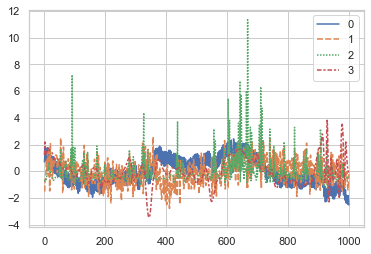

In [17]:
test_data = samples[2]
print(np.std(test_data[:, 2]))
sns.lineplot(data=test_data)

505


<AxesSubplot:>

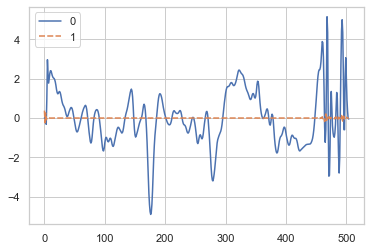

In [18]:
print(len(pywt.dwt(test_data[:, 1], 'db6', mode="zero")[0]))
sns.lineplot(data=pywt.dwt(test_data[:, 3], 'db6', mode="zero"))

<AxesSubplot:>

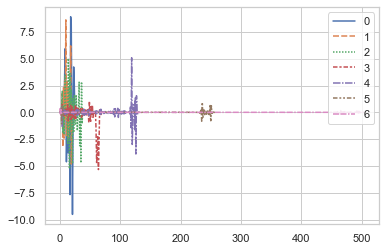

In [19]:
# transformed = np.fft.rfft(test_data[:512, 0], n=300)
transformed_wvlt_1 = pywt.wavedec(test_data[:, 1], 'db6', mode="zero")
transformed_wvlt_2 = pywt.wavedec(test_data[:, 3], 'db6', mode="zero")
# sns.lineplot(data=transformed)/
sns.lineplot(data=transformed_wvlt_2)

<AxesSubplot:>

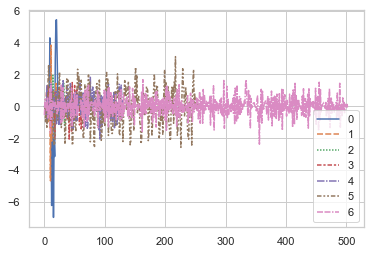

In [20]:
sns.lineplot(data=transformed_wvlt_1)



/opt/anaconda3/envs/neurahack/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


<AxesSubplot:>

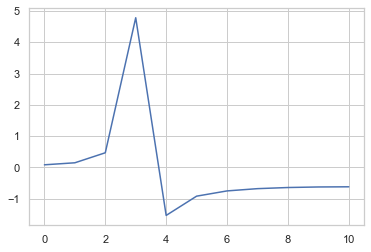

In [21]:
sns.lineplot(data=np.fft.rfft(np.sin(np.arange(512)), n=20))